# Thesis ABM model

Network model between agents that creates stochastic payment shocks then settles payments. Agents are affliliated to a bank. If with the same bank, settlement occurs in period. If with different bank, payment occurs every fourth period due to "batching".

## Configuring the model

In the Black Rhino framework, parameters are stored in xml files. Using this notebook, you can set change them. First, you need to import the elementree from the xml Python module.

In [20]:
import xml.etree.ElementTree as ET

Below you will find the parameter inputs for this model. Change the parameter values for different configurations of the model.

In [21]:
parameter_values = (('num_sweeps', '10'),
                    ('num_simulations', '1'),
                    ('num_households', '8'),
                    ('num_banks', '2'),
                    ('batch', '4'),
                    ('household_directory', 'agents/gen_households/'),
                    ('bank_directory', 'agents/gen_banks/'),
                    ('central_bank_directory', 'agents/central_bank/'),
                    ('measurement_config', 'measurements/test_output.xml')
                   )

To translate this to an xml document, which the framework can read, we first need create an ET element. 

In [22]:
environment = ET.Element('environment', identifier = "CBDC_parameters")

And create parameter elements and give them the values seen below to add to the tree object.

In [23]:
parameters = []
for x in range(len(parameter_values)):
    parameters.append(ET.SubElement(environment, 'parameter'))
    
for idx, p in enumerate(parameters):
    p.set('type', 'static')
    p.set('name', parameter_values[idx][0])
    p.set('value', parameter_values[idx][1])

This object can now be transformed to a string and written to an xml file using the code below. 

In [24]:
xml_params = ET.tostring(environment, encoding="UTF-8")
myfile = open("environments/CBDC_parameters.xml", "w")
myfile.write(xml_params)
myfile.close()

Now, the parameter xml file has been generated and the model can be run. Before, running the model, you need to import a couple of extra modules. These are the Python logging module, the Black Rhino environment class, and the Black Rhino runner class.

In [25]:
import logging
import os
from src.environment import Environment
from src.runner import Runner

Then, before running the model, the logger needs to be initialized.

In [26]:
log_directory = "log/"
identifier = "/CBDC_parameters"
environment_directory = "environments/"
if not os.path.exists('log'):
    os.makedirs('log')
logging.basicConfig(format='%(asctime)s %(message)s', datefmt='%m/%d/%Y %H:%M:%S',
                    filename=log_directory + identifier + ".log", level=logging.INFO)
logging.info('START logging for run: %s',  environment_directory + identifier + ".xml")

Generate banks and households using the generate agents class. First remove any agents still in directories. Then generate agents, the number of households and banks needs to be specified. In the generate banks method, the number of banks is the second argument. In the generate households method, the number of households it the second argument and the number of banks is the thrid argument.

In [27]:
import os
remove = True

bank_dir = os.getcwd()+'/agents/gen_banks/'
house_dir = os.getcwd()+'/agents/gen_households/'
if remove:
    bank_list = [ f for f in os.listdir(bank_dir) if f.startswith("bank") ]
    house_list = [ f for f in os.listdir(house_dir) if f.startswith("house") ]
for f in bank_list:
    os.remove(os.path.join(bank_dir, f))
for f in house_list:
    os.remove(os.path.join(house_dir, f))


In [28]:
from src.br_generate_agents import Generate_Agents
gen_agents = Generate_Agents()

gen_agents.generate_households(parameter_values[2][1], parameter_values[3][1], "./agents/gen_households/")

gen_agents.generate_banks(parameter_values[3][1], "./agents/gen_banks/")

First, the environment will be initialized. It contains the model parameters and variables. The environment also contains a list of agents. In the Solow model, the environment contains one bank, one firm, and one household. Finally, it also contains initialized transactions for these agents.

In [29]:
environment = Environment(environment_directory, identifier)

Next up, the runner object is created. As the name suggests, the runner object handles the running of the model. But that is not all, it also initializes the updater.

In [30]:
runner = Runner(environment)

Now you can actually run the model. Since the agent-based model is simulated using Monte Carlo methods. This means that the model will be run multiple times (num_simulations). For every simulation run, the environment and runner will be (re-)initialized. Then, the runner will run the Solow model. During the run, the runner will write data about capital to a csv file specified within the Measurement class and print out all the transactions happening and the books of firm and household at the end of each sweep.

In [31]:
for i in range(int(environment.num_simulations)):
    logging.info('  STARTED with run %s',  str(i))
    environment.initialize(environment_directory,  identifier)
    runner.initialize(environment)
    
    runner.do_run(environment)
    logging.info('  DONE')

measurements/test_output.xml
bank_0 has 48.0 reserves, and 48.0 Open Market Transactions
bank_1 has 48.0 reserves, and 48.0 Open Market Transactions
CBDC settlement of household_3_1 to 5.35849034265 complete
Bank Notes settlement of household_3_1 to 0.0 complete
household_3_1 chose 18.6415096573 deposits, 5.35849034265 cbdc, and 0.0 bank_notes
CBDC settlement of household_1_0 to 9.02969404463 complete
Bank Notes settlement of household_1_0 to 0.0 complete
household_1_0 chose 14.9703059554 deposits, 9.02969404463 cbdc, and 0.0 bank_notes
CBDC settlement of household_5_0 to 7.22405045796 complete
Bank Notes settlement of household_5_0 to 0.0 complete
household_5_0 chose 16.775949542 deposits, 7.22405045796 cbdc, and 0.0 bank_notes
CBDC settlement of household_7_0 to 12.9680622453 complete
Bank Notes settlement of household_7_0 to 0.0 complete
household_7_0 chose 11.0319377547 deposits, 12.9680622453 cbdc, and 0.0 bank_notes
CBDC settlement of household_0_0 to 6.64803780485 complete
Bank 

In [32]:
import pandas as pd
thesis_data = pd.read_csv('measurements/TestMeasurement.csv', index_col=0) 

In [34]:
print(thesis_data.head(3))
print(thesis_data.tail(4))

      Deposit Balance        B_0        B_1  B_2  B_3  B_4  Total_Payments  \
Step                                                                         
1          120.428267  70.788622  49.639645  NaN  NaN  NaN        0.000000   
2          108.684782  69.931035  38.753748  NaN  NaN  NaN       58.970361   
3          103.826644  69.931035  33.895609  NaN  NaN  NaN      101.112252   

      CBDC Balance  Batch Balance  CBDC_Payments  Deposits_Payments  
Step                                                                 
1        71.571733       0.000000       0.000000           0.000000  
2        71.571733      11.743484      36.194939          22.775422  
3        71.571733      16.601623      60.029378          41.082874  
      Deposit Balance        B_0        B_1  B_2  B_3  B_4  Total_Payments  \
Step                                                                         
7           93.242900  70.785088  22.457812  NaN  NaN  NaN      322.077204   
8           93.242900  70

Check consistency of Households, Banks and Central Bank

In [35]:
bank = True
for banks in environment.banks:
    bank *= banks.check_consistency()
if bank:
    print("True")
else:
    print("False")

house = True
for houses in environment.banks:
    house *= houses.check_consistency()
if house:
    print("True")
else:
    print("False")

print(environment.central_bank[0].check_consistency())

True
True
True


In [36]:
import matplotlib.pyplot as plt

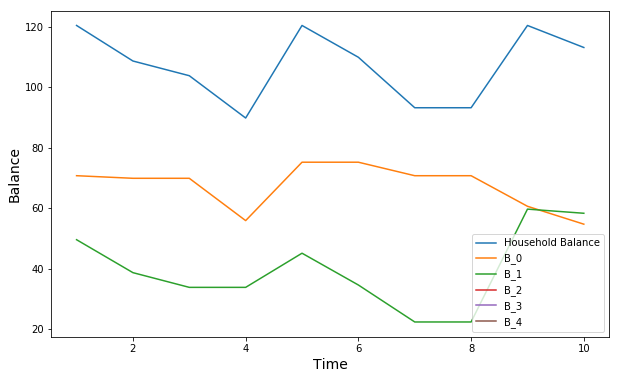

In [37]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,6))

ax.plot(thesis_data.index, thesis_data.drop(["Total_Payments", "CBDC Balance", "Batch Balance", "CBDC_Payments", "Deposits_Payments"], 1))
ax.set_xlabel('Time', fontsize='14')
ax.set_ylabel('Balance', fontsize='14')
ax.legend(['Household Balance', 'B_0', 'B_1', 'B_2', 'B_3', 'B_4'])

fig.savefig('deposit_balances.png')

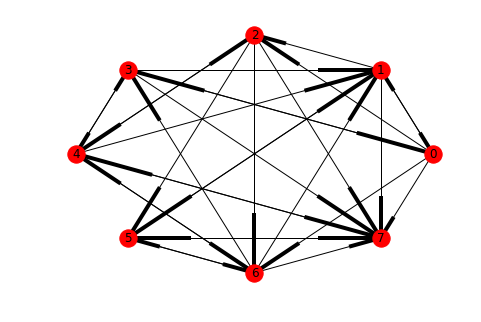

In [38]:
import networkx as nx
nx.draw_shell(environment.network)